# Contact Forces

To detect the forces in the legs, an environment is needed. This file is based on the environment created in the 1_Environment file. 

The following steps guide through which legs and what segments of the legs are chosen for obstacle detection to the choice of force thresholds based on the detected contact forces.

In [3]:
# import libraries
from flygym.mujoco.arena import BaseArena, FlatTerrain, GappedTerrain, BlocksTerrain, MixedTerrain
from flygym.mujoco.examples.obstacle_arena import ObstacleOdorArena
from flygym.mujoco.examples.turning_controller import HybridTurningNMF

from gymnasium.utils.env_checker import check_env

from IPython.display import Video
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

import flygym.common
import flygym.mujoco
import flygym.mujoco.preprogrammed
from flygym.mujoco import Parameters
from flygym.mujoco.arena import FlatTerrain

## Contact Force Detection

The following code shows how the observations of the contact forces for the front legs are summed up from the observation history given during simulation which will be similar to the way it is implemented in the final code.

In [ ]:
#THIS CODE IS JUST FOR SHOWING PURPOSES AND NOT PART OF THE ACTUAL MACHINE
#It also only shows the contact forces of the front legs

#contact_forces in x,y,z direction of all the segments(legs) in contact sensory placements (nmf.contact_sensor_placements)

#This gives back the contact forces of the five segments of the left and right leg 
#without the segment touching the ground -> Tarsus5

sensory_feedback_left = np.array([obs["contact_forces"][:5, :] for obs in obs_hist])
sensory_feedback_right = np.array([obs["contact_forces"][18:23, :] for obs in obs_hist])


#summed up contact forces of five of the six segments of the legs (left and right)
#axis = 1 to sum up each row of the contact forces of the five segments of the legs
#axis = 0 would sum up each column of the contact forces of the five segments of the legs

sensory_feedback_sum_left = sensory_feedback_left.sum(axis=1)
sensory_feedback_sum_right = sensory_feedback_right.sum(axis=1)

sensory_feedback = np.array([obs["contact_forces"] for obs in obs_hist])

## Contact Force Detection in the given Environment

The following code shows the implementation of observing the contact forces in the fly. The additions to the environment are marked with hashtag lines.

In [10]:
# visualization of the pillars in the environment 
# with a frame of the simulation

# We start by creating a simple arena
flat_terrain_arena = FlatTerrain()

# Then, we add visual and pillars on top of it
arena = ObstacleOdorArena(
    terrain=flat_terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (12.5, 5), (17.5, -5), (19,5)]),
    marker_size=0.5,
    obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.2, 0.8, 0.2, 1), (0.2, 0.2, 0.8, 1),(0.2, 0.2, 0.8, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
)

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    render_playspeed=0.2,
    render_camera="user_cam",
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
)
nmf = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(13, -5, 0.2),
    spawn_orientation=(0, 0, np.pi / 2 + np.deg2rad(70)),
    contact_sensor_placements=contact_sensor_placements,
)

###############################################

seed = 12
obs_hist = []
odor_history = []
obs, _ = nmf.reset(seed)
run_time = 2

for i in trange(int(run_time / nmf.sim_params.timestep)):
    curr_time = i 
    # Front legs ####################################
    left_sense = np.array(obs["contact_forces"][:5, 0:2])
    right_sense = np.array(obs["contact_forces"][18:23, 0:2])
    left_sense_sum = np.abs(left_sense).sum()
    right_sense_sum = np.abs(right_sense).sum()
    # Middle legs ####################################
    left_sense_middle = np.array(obs["contact_forces"][6:11, 0:2])
    right_sense_middle = np.array(obs["contact_forces"][24:29, 0:2])
    left_sense_middle_sum = np.abs(left_sense_middle).sum()
    right_sense_middle_sum = np.abs(right_sense_middle).sum()

    if i > 1000:
        obs, reward, terminated, truncated, info = nmf.step(np.array([1,1]))
    else:
        obs, _, _, _, _ = nmf.step(np.array([0, 0]), orig=False)

    obs_hist.append(obs)
    nmf.render()
    
nmf.save_video("./outputs/pillars.mp4")
Video("./outputs/pillars.mp4")



100%|██████████| 20000/20000 [02:04<00:00, 160.23it/s]


## Choice of Leg Segments and Force Thresholds

The following graphs show the observation of the forces experienced by the fly for the front and the middle legs.

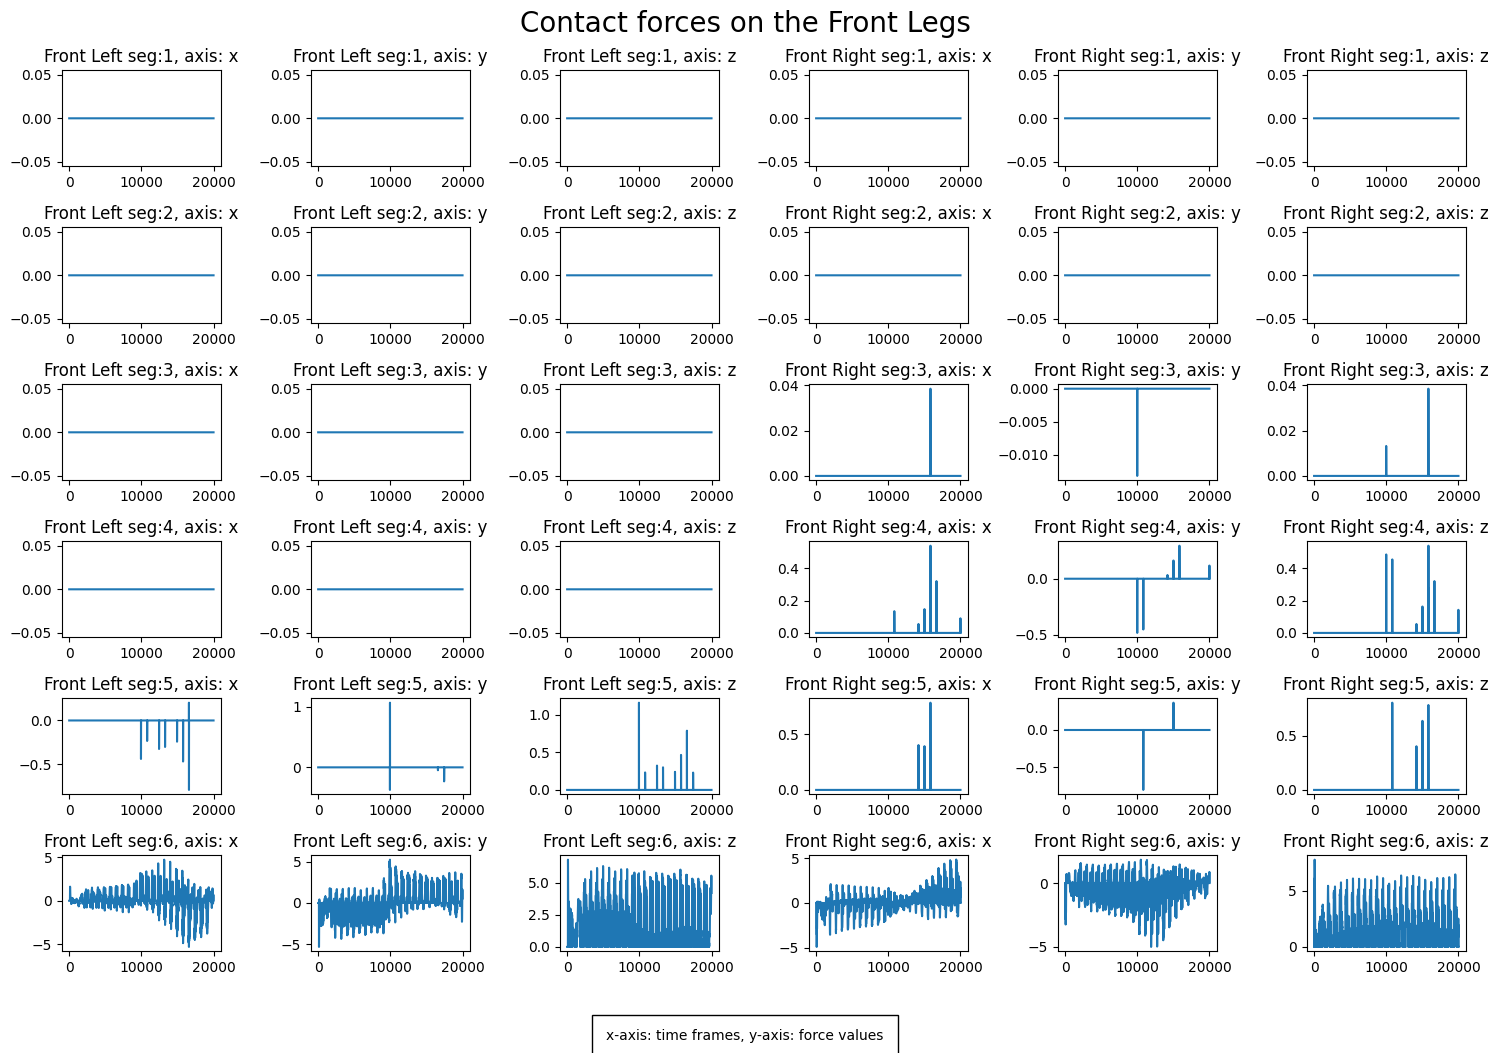

In [20]:
#FRONT LEGS

forces_left_front = np.array([obs["contact_forces"][:6] for obs in obs_hist])
forces_right_front = np.array([obs["contact_forces"][18:24] for obs in obs_hist])

# Plot the contact forces of the front legs
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(15, 10))
directions = ['x', 'y', 'z']


#for every segment of the front legs
for i in range(6):
    #and every direction
    for j in range(3):
        #left leg
        axs[i, j].plot(forces_left_front[:, i, j])
        axs[i, j].set_title(f'Front Left seg:{i+1}, axis: {directions[j]}')
        
        #right leg
        axs[i, j+3].plot(forces_right_front[:, i, j])
        axs[i, j+3].set_title(f'Front Right seg:{i+1}, axis: {directions[j]}')

axes_text = "x-axis: Time Frames, y-axis: Force Values"
fig.text(0.5, -0.05, axes_text, transform=fig.transFigure, horizontalalignment='center',fontsize=12, 
         bbox=dict(facecolor='none', edgecolor='black', boxstyle='square,pad=1'))

fig.suptitle("Contact forces on the Front Legs", fontsize=20)

plt.tight_layout()
plt.show()

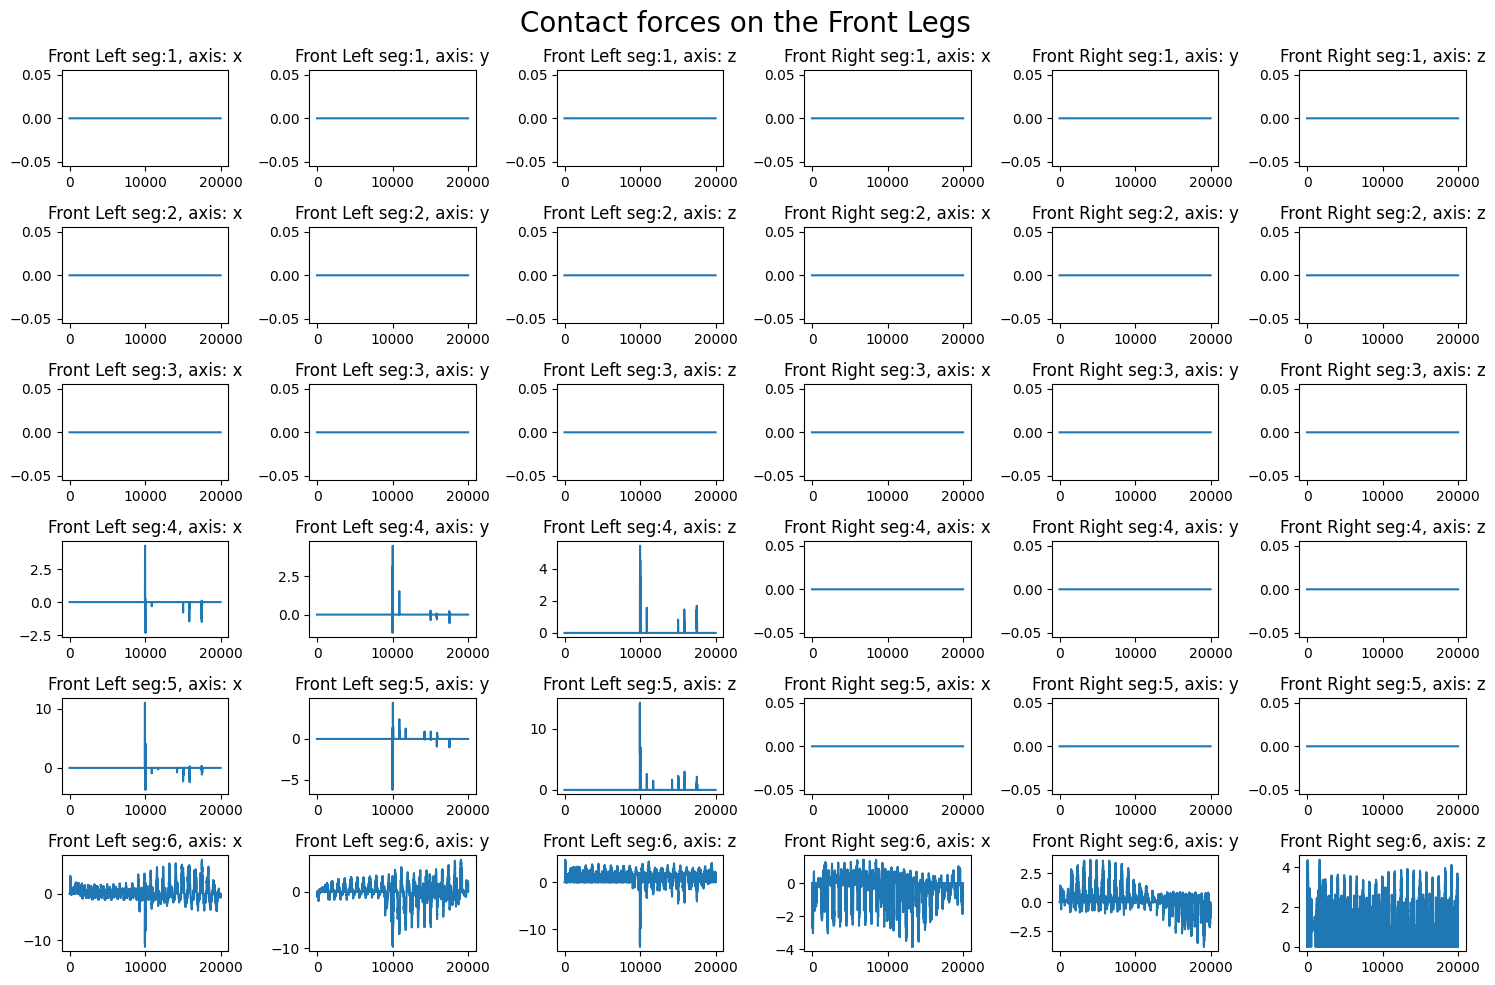

In [13]:
#MIDDLE LEGS

forces_left_front = np.array([obs["contact_forces"][6:12] for obs in obs_hist])
forces_right_front = np.array([obs["contact_forces"][24:30] for obs in obs_hist])

# Plot the contact forces of the front legs
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(15, 10))
directions = ['x', 'y', 'z']


#for every segment of the front legs
for i in range(6):
    #and every direction
    for j in range(3):
        #left leg
        axs[i, j].plot(forces_left_front[:, i, j])
        axs[i, j].set_title(f'Front Left seg:{i+1}, axis: {directions[j]}')
        
        #right leg
        axs[i, j+3].plot(forces_right_front[:, i, j])
        axs[i, j+3].set_title(f'Front Right seg:{i+1}, axis: {directions[j]}')

#fig.legend("x-axis: time frames, y-axis: force values")
fig.suptitle("Contact forces on the Front Legs", fontsize=20)

plt.tight_layout()
plt.show()


These observations lead to in the report mentioned conclusions for the low and high force thresholds.